# C-to-U editing detection from direct-RNA sequencing by Nanopore
## Per Read Current Visualization on site chr2:121983221

Focus on raw signals of reads mapping on the position chr2:12198322 that has a C (match) or T (mismatch) to understand when T mismatches are due to editing or error in basecalling by Guppy.

In [1]:
# importing basic modules
import pandas as pd
import numpy as np
import os, sys
import pysam
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
# setting principal variable
ko_bam_path = "ko.bam"
wt_bam_path = "wt.bam"
ref_path = "/home/adri/refs/ref_mm39/Mus_musculus.GRCm39.dna.primary_assembly.fa"

chrom = "2"
pos_1_based = 121983221
pos_0based = pos_1_based - 1
start = pos_0based - 4
stop = pos_0based + 5 # right opened interval for pysam (python way)

In [3]:
ref = pysam.FastaFile(ref_path)
ref.fetch(chrom, start, stop)

'TGTACACAT'

In [4]:
# loading the 4 datasets
ko_eventalign_C_path = "ko.eventalign_C"
ko_eventalign_T_path = "ko.eventalign_T"
wt_eventalign_C_path = "wt.eventalign_C"
wt_eventalign_T_path = "wt.eventalign_T"

# set columns names
columns = "contig position reference_kmer read_name strand event_index event_level_mean event_stdv event_length model_kmer model_mean model_stdv standardized_level start_idx end_idx samples".split(" ")

# loading into Pandas.DataFrame objects
df_ko_eventalign_C = pd.read_table(ko_eventalign_C_path, header = None, index_col=None)
df_ko_eventalign_T = pd.read_table(ko_eventalign_T_path, header = None, index_col=None)
df_wt_eventalign_C = pd.read_table(wt_eventalign_C_path, header = None, index_col=None)
df_wt_eventalign_T = pd.read_table(wt_eventalign_T_path, header = None, index_col=None)

# setting columns' names
df_ko_eventalign_C.columns = columns
df_ko_eventalign_T.columns = columns
df_wt_eventalign_C.columns = columns
df_wt_eventalign_T.columns = columns

print("Events KO C:", df_ko_eventalign_C.shape[0])
print("Events KO T:", df_ko_eventalign_T.shape[0])
print("Events WT C:", df_wt_eventalign_C.shape[0])
print("Events WT T:", df_wt_eventalign_T.shape[0])

Events KO C: 297589
Events KO T: 16514
Events WT C: 201913
Events WT T: 135615


In [5]:
# def. aggregation function for samples
def agg_samples(x):
    '''
    Function to aggregate samples feature in the groupby operation
    merging all samples from the same event mapping onto a position
    into a unique list of float values 
    '''
    final = list( map(float, ",".join(x).split(",")))
    #final = ""
    #for e in x:
        #final += e
        #final += ","
        #final_list = final.rstrip(",").split(",")
        #final_map = list(map(float, final_list))
    return final
    

# defining custom function for preprocessing of filtered eventalign dataframes.
def preprocess_filtered_eventalign_tables(df, position_0_based):
    
    '''
    (ONLY RNA! FOR DNA THE START POSITION SHOULD BE 5!)
    Function to preprocess and collapse events mapping on the same position and kmer 
    like to nanoRMS.
    This function also perform a selection of events around a position given as input 
    so that the events contains at least in one kmer position the position/base of interest.
    It takes in input:
        - df --> dataframe pandas of filtered eventalign output.
        - position_0:based --> position 0 based of the site of interest
    '''
    start = position_0_based - 4
    stop = position_0_based
    
    # filtering events with NNNNN model_kmer
    df = df[df["model_kmer"] != "NNNNN"]
    #Collapsing multiple observations from the same read on position and ref. kmer
    df_grouped = df.groupby(["contig", "position", "reference_kmer", "read_name"]).agg({"samples":[agg_samples]})
    # resetting index and columns' names
    df_grouped = df_grouped.reset_index()
    df_grouped.columns =  df_grouped.columns.droplevel(-1)
    # filtering only events that maps the base at the requested position 0 based
    df_grouped_pos_filtered = df_grouped[(df_grouped["position"] >= pos_0based-4) & (df_grouped["position"] <= pos_0based)].copy()
    # create dwell, weighted average of event_level_mean and event_level_std colums from elements in the merged samples list
    df_grouped_pos_filtered["event_level_mean"] = df_grouped_pos_filtered["samples"].apply(np.mean)
    df_grouped_pos_filtered["event_level_std"] = df_grouped_pos_filtered["samples"].apply(np.std)
    df_grouped_pos_filtered["dwell"] = df_grouped_pos_filtered["samples"].apply(len).values
    df_grouped_pos_filtered.drop("samples", axis=1, inplace=True)
    df_grouped_pos_filtered.sort_values(["contig", "read_name"], inplace=True)
    df_grouped_pos_filtered.reset_index(drop=True, inplace=True)
    
    return df_grouped_pos_filtered

In [6]:
# preprocessing dataframes using the custom function
df_filt_ko_C = preprocess_filtered_eventalign_tables(df_ko_eventalign_C, pos_0based)
df_filt_ko_T = preprocess_filtered_eventalign_tables(df_ko_eventalign_T, pos_0based)
df_filt_wt_C = preprocess_filtered_eventalign_tables(df_wt_eventalign_C, pos_0based)
df_filt_wt_T = preprocess_filtered_eventalign_tables(df_wt_eventalign_T, pos_0based)

# printing shapes
print("KO C base collapsed events filtered by pos. shape", df_filt_ko_C.shape[0])
print("KO T base collapsed events filtered by pos. shape", df_filt_ko_T.shape[0])
print("WT C base collapsed events filtered by pos. shape", df_filt_wt_C.shape[0])
print("WT T base collapsed events filtered by pos. shape", df_filt_wt_T.shape[0])

KO C base collapsed events filtered by pos. shape 1521
KO T base collapsed events filtered by pos. shape 89
WT C base collapsed events filtered by pos. shape 967
WT T base collapsed events filtered by pos. shape 515


In [7]:
df_filt_ko_C

,contig,position,reference_kmer,read_name,event_level_mean,event_level_std,dwell
0,chr2,121983216,TGTAC,0194a1d0-2fa0-48f0-bfb6-7647f0361d40,95.872006,11.832575,18
1,chr2,121983217,GTACA,0194a1d0-2fa0-48f0-bfb6-7647f0361d40,75.369864,1.968384,22
2,chr2,121983218,TACAC,0194a1d0-2fa0-48f0-bfb6-7647f0361d40,81.030138,3.207067,13
3,chr2,121983219,ACACA,0194a1d0-2fa0-48f0-bfb6-7647f0361d40,72.251196,2.815546,45
4,chr2,121983220,CACAT,0194a1d0-2fa0-48f0-bfb6-7647f0361d40,79.563969,1.431583,13
...,...,...,...,...,...,...,...
1516,chr2,121983216,TGTAC,ff27567c-4076-436c-9941-32753f3843a8,108.165552,12.106168,33
1517,chr2,121983217,GTACA,ff27567c-4076-436c-9941-32753f3843a8,77.040740,3.660641,15
1518,chr2,121983218,TACAC,ff27567c-4076-436c-9941-32753f3843a8,79.873325,2.091976,16
1519,chr2,121983219,ACACA,ff27567c-4076-436c-9941-32753f3843a8,74.587635,2.724226,37


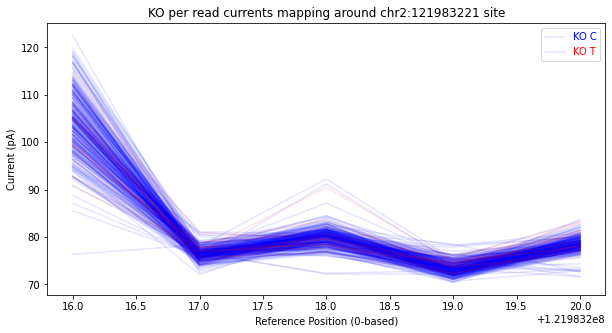

In [8]:
# Visualizing all the KO reads, C vs T mapped.
plt.figure(figsize=(10,5))

for read in df_filt_ko_C.read_name.unique():
    if df_filt_ko_C[df_filt_ko_C["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_ko_C[df_filt_ko_C["read_name"] == read].sort_values(by="position").position, 
                  df_filt_ko_C[df_filt_ko_C["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="b",
                  alpha = 0.1)

for read in df_filt_ko_T.read_name.unique():
    if df_filt_ko_T[df_filt_ko_T["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_ko_T[df_filt_ko_T["read_name"] == read].sort_values(by="position").position, 
                  df_filt_ko_T[df_filt_ko_T["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="r",
                  alpha = 0.1)

        
plt.title("KO per read currents mapping around chr2:121983221 site")
plt.xlabel("Reference Position (0-based)")
plt.ylabel("Current (pA)")
plt.legend(["KO C", "KO T"], labelcolor=["blue", "red"])
plt.show()

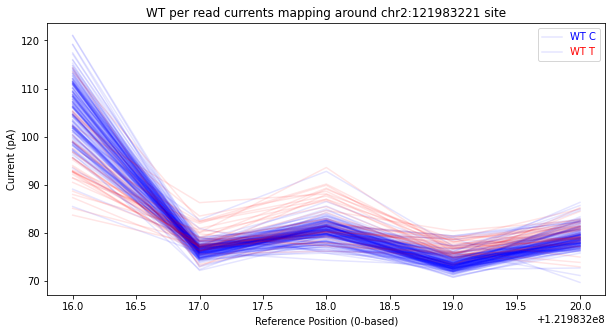

In [9]:
# Visualizing all the WT reads, C vs T mapped.
plt.figure(figsize=(10,5))

for read in df_filt_wt_C.read_name.unique():
    if df_filt_wt_C[df_filt_wt_C["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_wt_C[df_filt_wt_C["read_name"] == read].sort_values(by="position").position, 
                  df_filt_wt_C[df_filt_wt_C["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="b",
                  alpha = 0.1)

for read in df_filt_wt_T.read_name.unique():
    if df_filt_wt_T[df_filt_wt_T["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_wt_T[df_filt_wt_T["read_name"] == read].sort_values(by="position").position, 
                  df_filt_wt_T[df_filt_wt_T["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="r",
                  alpha = 0.1)

        
plt.title("WT per read currents mapping around chr2:121983221 site")
plt.xlabel("Reference Position (0-based)")
plt.ylabel("Current (pA)")
plt.legend(["WT C", "WT T"], labelcolor=["blue", "red"])
plt.show()

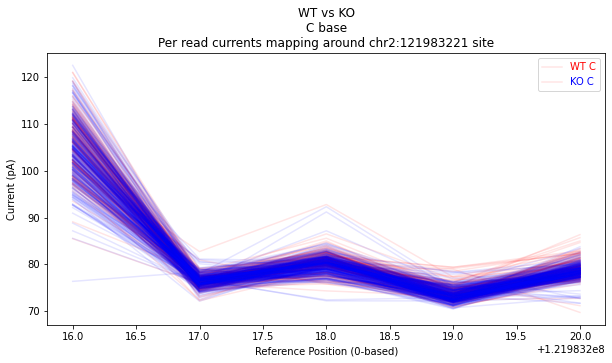

In [10]:
# Visualizing all the reads C mapped, WT vs KO.
plt.figure(figsize=(10,5))

for read in df_filt_wt_C.read_name.unique():
    if df_filt_wt_C[df_filt_wt_C["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_wt_C[df_filt_wt_C["read_name"] == read].sort_values(by="position").position, 
                  df_filt_wt_C[df_filt_wt_C["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="r",
                  alpha = 0.1)

for read in df_filt_ko_C.read_name.unique():
    if df_filt_ko_C[df_filt_ko_C["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_ko_C[df_filt_ko_C["read_name"] == read].sort_values(by="position").position, 
                  df_filt_ko_C[df_filt_ko_C["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="b",
                  alpha = 0.1)

        
plt.title("WT vs KO\nC base\nPer read currents mapping around chr2:121983221 site")
plt.xlabel("Reference Position (0-based)")
plt.ylabel("Current (pA)")
plt.legend(["WT C", "KO C"], labelcolor=["red", "blue"])
plt.show()

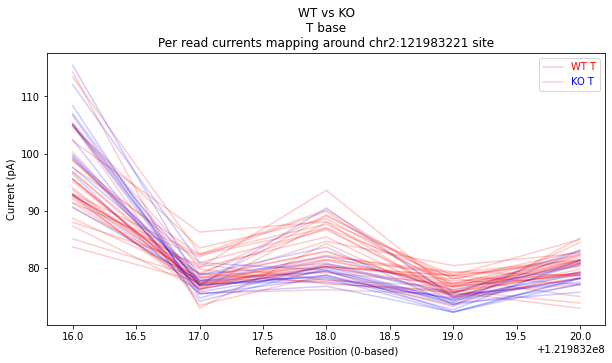

In [11]:
# Visualizing all the reads T mapped, WT vs KO.
plt.figure(figsize=(10,5))

for read in df_filt_wt_T.read_name.unique():
    if df_filt_wt_T[df_filt_wt_T["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_wt_T[df_filt_wt_T["read_name"] == read].sort_values(by="position").position, 
                  df_filt_wt_T[df_filt_wt_T["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="r",
                  alpha = 0.2)

for read in df_filt_ko_T.read_name.unique():
    if df_filt_ko_T[df_filt_ko_T["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_ko_T[df_filt_ko_T["read_name"] == read].sort_values(by="position").position, 
                  df_filt_ko_T[df_filt_ko_T["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="b",
                  alpha = 0.2)

        
plt.title("WT vs KO\nT base\nPer read currents mapping around chr2:121983221 site")
plt.xlabel("Reference Position (0-based)")
plt.ylabel("Current (pA)")
plt.legend(["WT T", "KO T"], labelcolor=["red", "blue"])
plt.show()

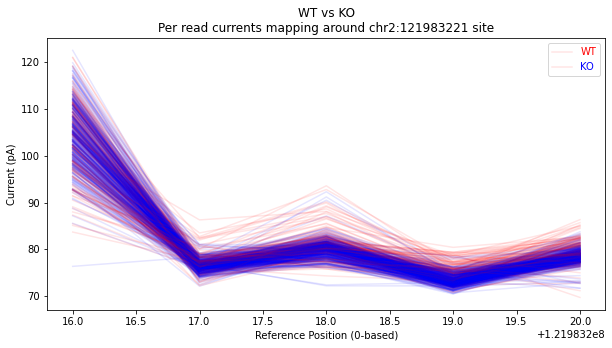

In [12]:
# Visualizing all the reads (no C or T mapped distinction) WT vs KO.
plt.figure(figsize=(10,5))


for read in df_filt_wt_C.read_name.unique():
    if df_filt_wt_C[df_filt_wt_C["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_wt_C[df_filt_wt_C["read_name"] == read].sort_values(by="position").position, 
                  df_filt_wt_C[df_filt_wt_C["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="r",
                  alpha = 0.1)

for read in df_filt_ko_C.read_name.unique():
    if df_filt_ko_C[df_filt_ko_C["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_ko_C[df_filt_ko_C["read_name"] == read].sort_values(by="position").position, 
                  df_filt_ko_C[df_filt_ko_C["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="b",
                  alpha = 0.1)


for read in df_filt_wt_T.read_name.unique():
    if df_filt_wt_T[df_filt_wt_T["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_wt_T[df_filt_wt_T["read_name"] == read].sort_values(by="position").position, 
                  df_filt_wt_T[df_filt_wt_T["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="r",
                  alpha = 0.1)

for read in df_filt_ko_T.read_name.unique():
    if df_filt_ko_T[df_filt_ko_T["read_name"] == read].sort_values(by="position").shape[0] == 5:
        plt.plot( df_filt_ko_T[df_filt_ko_T["read_name"] == read].sort_values(by="position").position, 
                  df_filt_ko_T[df_filt_ko_T["read_name"] == read].sort_values(by="position").event_level_mean, 
                  c="b",
                  alpha = 0.1)

        
plt.title("WT vs KO\nPer read currents mapping around chr2:121983221 site")
plt.xlabel("Reference Position (0-based)")
plt.ylabel("Current (pA)")
plt.legend(["WT", "KO"], labelcolor=["red", "blue"])
plt.show()

## Perform PCA of currents on the 5 position per read
First of all we have to extract all the 5 current values in the 5 position for each read.

In [95]:
# importing module for PCA 
from sklearn.decomposition import PCA

Dimension:  (171, 5)


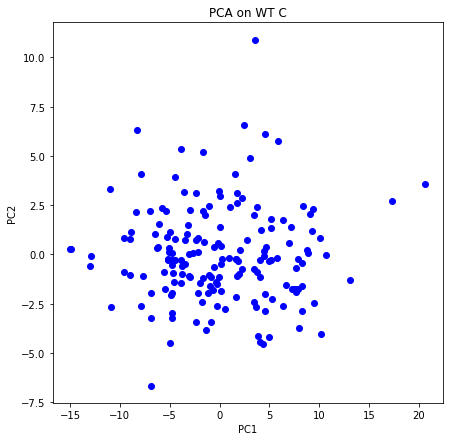

In [121]:
# computations for WT_C

data = df_filt_wt_C.copy()

# filtering reads with less than 5 events
filt_data = np.empty([0,5])
y = []

for read in data.read_name.unique():
    if data[data["read_name"] == read].sort_values(by="position").shape[0] == 5: 
        filt_data = np.append( filt_data, 
                              data[data["read_name"] == read].sort_values(by="position")["event_level_mean"].values.reshape(1, 5),
                              axis=0 )

print("Dimension: ", filt_data.shape)

# performing PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filt_data)

# plotting figure
plt.figure(figsize=(7,7))
plt.scatter(pca_data[:,0], pca_data[:,1], c="Blue")
plt.title("PCA on WT C")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Dimension:  (36, 5)


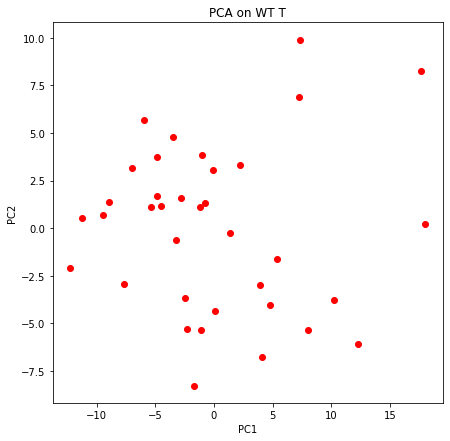

In [122]:
# computations for WT_T

data = df_filt_wt_T.copy()

# filtering reads with less than 5 events
filt_data = np.empty([0,5])
y = []

for read in data.read_name.unique():
    if data[data["read_name"] == read].sort_values(by="position").shape[0] == 5: 
        filt_data = np.append( filt_data, 
                              data[data["read_name"] == read].sort_values(by="position")["event_level_mean"].values.reshape(1, 5),
                              axis=0 )

print("Dimension: ", filt_data.shape)

# performing PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filt_data)

# plotting figure
plt.figure(figsize=(7,7))
plt.scatter(pca_data[:,0], pca_data[:,1], c="Red")
plt.title("PCA on WT T")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Dimension: (207, 5)
Label Dimension; 207


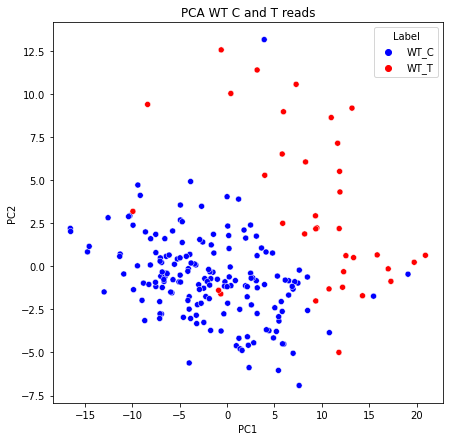

In [130]:
# computation for whole WT C and WT T

data_1 = df_filt_wt_C.copy()
data_2 = df_filt_wt_T.copy()

datas = [data_1, data_2]
labels = ["WT_C", "WT_T"]
title = "PCA WT C and T reads"

# filtering reads with less than 5 events
filt_data = np.empty([0,5])
y = []

for data, label in zip(datas, labels):
    for read in data.read_name.unique():
        if data[data["read_name"] == read].sort_values(by="position").shape[0] == 5: 
            filt_data = np.append( filt_data, 
                                  data[data["read_name"] == read].sort_values(by="position")["event_level_mean"].values.reshape(1, 5),
                                  axis=0 )
            y.append(label)

print("Dimension:", filt_data.shape)
print("Label Dimension;", len(y))

# performing PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filt_data)
df_pca_data = pd.DataFrame(pca_data, columns=["PC1", "PC2"])
df_pca_data["Label"] = y

# plotting figure
plt.figure(figsize=(7,7))
sn.scatterplot(data=df_pca_data, x="PC1", y="PC2", hue="Label", palette=["Blue", "Red"])
plt.title(title)
plt.show()

Dimension:  (286, 5)


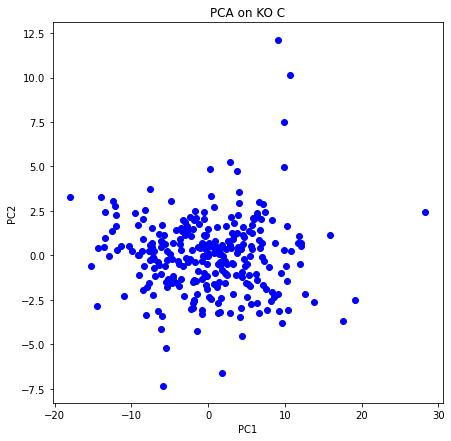

In [131]:
# computations for KO_C

data = df_filt_ko_C.copy()

# filtering reads with less than 5 events
filt_data = np.empty([0,5])
y = []

for read in data.read_name.unique():
    if data[data["read_name"] == read].sort_values(by="position").shape[0] == 5: 
        filt_data = np.append( filt_data, 
                              data[data["read_name"] == read].sort_values(by="position")["event_level_mean"].values.reshape(1, 5),
                              axis=0 )

print("Dimension: ", filt_data.shape)

# performing PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filt_data)

# plotting figure
plt.figure(figsize=(7,7))
plt.scatter(pca_data[:,0], pca_data[:,1], c="Blue")
plt.title("PCA on KO C")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Dimension:  (16, 5)


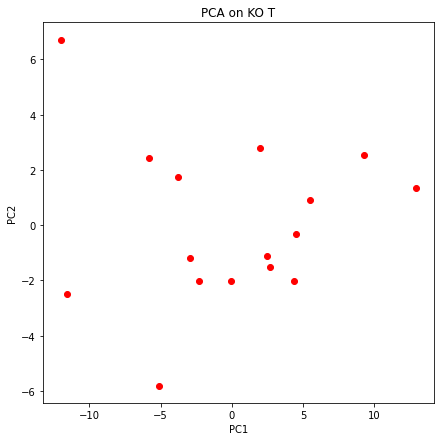

In [132]:
# computations for KO_T

data = df_filt_ko_T.copy()

# filtering reads with less than 5 events
filt_data = np.empty([0,5])
y = []

for read in data.read_name.unique():
    if data[data["read_name"] == read].sort_values(by="position").shape[0] == 5: 
        filt_data = np.append( filt_data, 
                              data[data["read_name"] == read].sort_values(by="position")["event_level_mean"].values.reshape(1, 5),
                              axis=0 )

print("Dimension: ", filt_data.shape)

# performing PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filt_data)

# plotting figure
plt.figure(figsize=(7,7))
plt.scatter(pca_data[:,0], pca_data[:,1], c="Red")
plt.title("PCA on KO T")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Dimension: (302, 5)
Label Dimension; 302


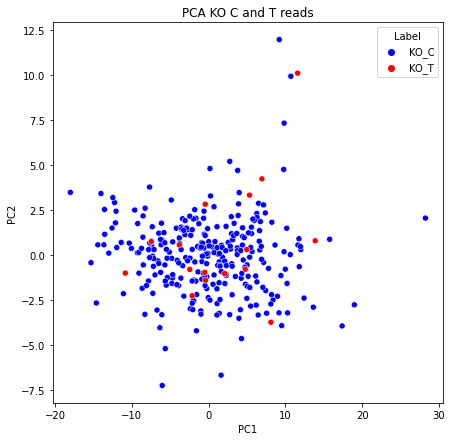

In [134]:
# computation for whole KO C and KO T

data_1 = df_filt_ko_C.copy()
data_2 = df_filt_ko_T.copy()

datas = [data_1, data_2]
labels = ["KO_C", "KO_T"]
title = "PCA KO C and T reads"

# filtering reads with less than 5 events
filt_data = np.empty([0,5])
y = []

for data, label in zip(datas, labels):
    for read in data.read_name.unique():
        if data[data["read_name"] == read].sort_values(by="position").shape[0] == 5: 
            filt_data = np.append( filt_data, 
                                  data[data["read_name"] == read].sort_values(by="position")["event_level_mean"].values.reshape(1, 5),
                                  axis=0 )
            y.append(label)

print("Dimension:", filt_data.shape)
print("Label Dimension;", len(y))

# performing PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filt_data)
df_pca_data = pd.DataFrame(pca_data, columns=["PC1", "PC2"])
df_pca_data["Label"] = y

# plotting figure
plt.figure(figsize=(7,7))
sn.scatterplot(data=df_pca_data, x="PC1", y="PC2", hue="Label", palette=["Blue", "Red"])
plt.title(title)
plt.show()

Dimension: (509, 5)
Label Dimension; 509


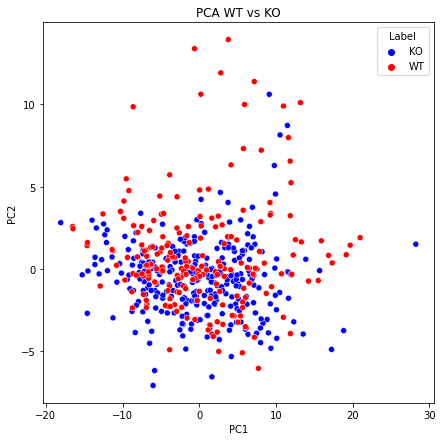

In [135]:
# computation for whole WT and KO

data_1 = df_filt_ko_C.copy()
data_2 = df_filt_ko_T.copy()
data_3 = df_filt_wt_C.copy()
data_4 = df_filt_wt_T.copy()

datas = [data_1, data_2, data_3, data_4]
labels = ["KO", "KO", "WT", "WT"]
title = "PCA WT vs KO"

# filtering reads with less than 5 events
filt_data = np.empty([0,5])
y = []

for data, label in zip(datas, labels):
    for read in data.read_name.unique():
        if data[data["read_name"] == read].sort_values(by="position").shape[0] == 5: 
            filt_data = np.append( filt_data, 
                                  data[data["read_name"] == read].sort_values(by="position")["event_level_mean"].values.reshape(1, 5),
                                  axis=0 )
            y.append(label)

print("Dimension:", filt_data.shape)
print("Label Dimension;", len(y))

# performing PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(filt_data)
df_pca_data = pd.DataFrame(pca_data, columns=["PC1", "PC2"])
df_pca_data["Label"] = y

# plotting figure
plt.figure(figsize=(7,7))
sn.scatterplot(data=df_pca_data, x="PC1", y="PC2", hue="Label", palette=["Blue", "Red"])
plt.title(title)
plt.show()